# Compare REZ capacity factors

In [190]:
client.close()
cluster.close()

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
PROJECT = "dt6"

In [3]:
walltime = "03:00:00"
cores = 12
memory = str(4 * cores) + "GB"

cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    processes=cores,
    job_extra_directives=[
        "-q normal",
        "-P "+PROJECT,
        "-l ncpus="+str(cores),
        "-l mem="+str(memory),
        "-l storage=gdata/xp65+gdata/w42+scratch/w42+gdata/gb02+scratch/gb02+gdata/ng72+scratch/ng72+gdata/rt52"
    ],
    local_directory="$TMPDIR",
    job_directives_skip=["select"],
    log_directory="/scratch/w42/dr6273/tmp/logs"
)

In [4]:
cluster.scale(jobs=1)
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.2:46007,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [7]:
%cd /g/data/w42/dr6273/work/wind_power_comparison/
import functions as fn

/g/data/w42/dr6273/work/wind_power_comparison


In [8]:
%load_ext autoreload
%autoreload 2

## Load data

BARRA-C2 Capacity factor

In [9]:
rez_mask_barra_c2 = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_BARRA-C2_grid.nc"
)["REZ"]

In [10]:
cf_barra = fn.load_barra_c2_capacity_factor().cf100m

In [11]:
cf_barra

<xarray.DataArray 'cf100m' (time: 341856, lat: 737, lon: 506)> Size: 510GB
dask.array<concatenate, shape=(341856, 737, 506), dtype=float32, chunksize=(72, 737, 506), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B ...
    height   float64 8B ...
  * lat      (lat) float64 6kB -43.37 -43.33 -43.29 ... -14.01 -13.97 -13.93
  * lon      (lon) float64 4kB 133.5 133.5 133.6 133.6 ... 153.6 153.7 153.7
  * time     (time) datetime64[ns] 3MB 2011-01-01 ... 2023-12-31T23:40:00

Pre-computed REZ means for BARRA-C2

In [12]:
rez_means_barra_20m = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_BARRA-C2_2011-2023_20min.csv",
    index_col=0
)

REZ-mean for 1hr data (just select each 20-min timestep on the hour)

In [13]:
rez_means_barra_1hr = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_BARRA-C2_2011-2023_1hr.csv",
    index_col=0
)

REZ-mean for 3hr data

In [14]:
rez_means_barra_3hr = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_BARRA-C2_2011-2023_3hr.csv",
    index_col=0
)

REZ-mean for 12hr data

In [15]:
rez_means_barra_12hr = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_BARRA-C2_2011-2023_12hr.csv",
    index_col=0
)

REZ-mean for 24hr data

In [16]:
rez_means_barra_24hr = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_BARRA-C2_2011-2023_24hr.csv",
    index_col=0
)

REZ-mean for 1-week (168 hours) data

In [17]:
rez_means_barra_1wk = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/wind_comparison/capacity_factor_REZ_mean_BARRA-C2_2011-2023_168hr.csv",
    index_col=0
)

Load AEMO and ERA5 stats

In [18]:
# Load AEMO obs and ERA5 REZ stats
cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/capacity_factor/van_der_Wiel/bias_corrected/"

rez_means_era5_aemo = pd.read_csv(
    cf_path + "wind_medium_capacity_factor_van_der_Wiel_era5_REZ_statistics.csv",
    index_col=0
)

Text(0.5, 0, 'REZ')

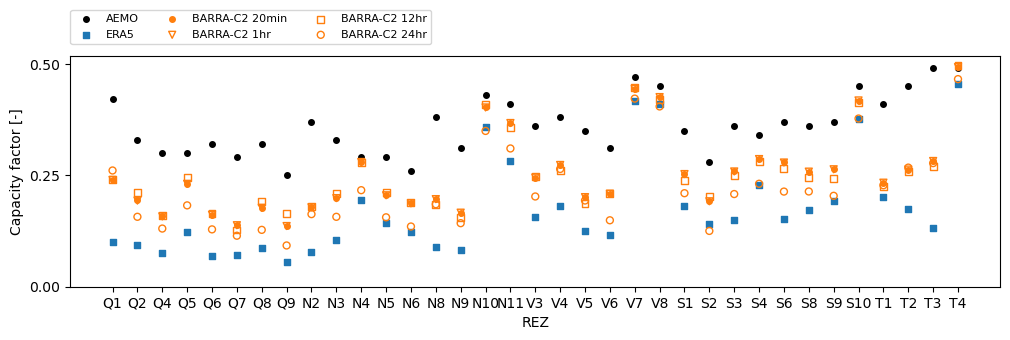

In [26]:
fig, ax = plt.subplots(figsize=(12,3))
s = 16
ylim = 0.5

rez_means_era5_aemo.reset_index().plot.scatter(ax=ax, x="index", y="obs_mean", color="k", s=s, label="AEMO")
rez_means_era5_aemo.reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:blue", s=s, marker="s", label="ERA5")

rez_means_barra_20m.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:orange", s=s, marker="o", label="BARRA-C2 20min")
rez_means_barra_1hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="v", label="BARRA-C2 1hr")
# rez_means_barra_3hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="X", label="BARRA-C2 3hr")
rez_means_barra_12hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="s", label="BARRA-C2 12hr")
rez_means_barra_24hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="o", label="BARRA-C2 24hr")
# rez_means_barra_1wk.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="^", label="BARRA-C2 1wk")

# rez_means_barra_20m.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_weighted_mean", color="tab:green", s=s, marker="o", label="BARRA-C2 20min weighted mean")

ax.legend(ncols=3, fontsize=8, loc=(0, 1.05))
ax.set_yticks([0, ylim/2, ylim])
ax.set_ylabel("Capacity factor [-]")
ax.set_xlabel("REZ")

#### Spatial variability

In [30]:
def rez_time_mean(cf_da, mask, rez):
    """
    Return time-mean of capacity factors for a REZ

    cf_da: array, capacity factor data
    mask: array, mask of REZ regions
    rez: str, REZ e.g. 'Q1'
    """
    return cf_da.where(mask.sel(region=rez), drop=True).mean("time")

In [32]:
q1_mean = rez_time_mean(cf_barra, rez_mask_barra_c2, "Q1").compute()

In [ ]:
n3_mean = rez_time_mean(cf_barra, rez_mask_barra_c2, "N3").compute()

In [ ]:
# v8_mean = rez_time_mean(cf_barra, rez_mask_barra_c2, "V8").compute()

In [ ]:
# s6_mean = rez_time_mean(cf_barra, rez_mask_barra_c2, "S6").compute()

In [ ]:
# t3_mean = rez_time_mean(cf_barra, rez_mask_barra_c2, "T3").compute()

In [33]:
def find_cf_threshold(rez, rez_mean_da):
    """
    Find the smallest capacity factor threshold such that mean of rez_mean_da is equal to AEMO's capacity factor
    
    rez: str, REZ e.g. 'Q1'
    rez_mean_da: DataArray, average capacity factors with dimensions lat, lon
    """
    thresholds = np.arange(0, 1.01, 0.01)
    target = rez_means_era5_aemo.loc[rez]["obs_mean"] - 0.1
    
    i = 0
    t = 0
    all_rez_mean = np.round(rez_mean_da.mean().values, 2)
    # print(all_rez_mean)
    while all_rez_mean < target:
        i += 1
        t = thresholds[i]
        all_rez_mean = np.round(rez_mean_da.where(rez_mean_da >= t).mean().values, 2)
        # print(t, all_rez_mean)
        
    return t, all_rez_mean

In [133]:
q1_thresh, q1_thresh_mean = find_cf_threshold("Q1", q1_mean)
print(q1_thresh, q1_thresh_mean)

0.23 0.33


In [134]:
n3_thresh, n3_thresh_mean = find_cf_threshold("N3", n3_mean)
print(n3_thresh, n3_thresh_mean)

0.2 0.23


In [34]:
# v8_thresh, v8_thresh_mean = find_cf_threshold("V8", v8_mean)
# print(v8_thresh, v8_thresh_mean)

In [35]:
# s6_thresh, s6_thresh_mean = find_cf_threshold("S6", s6_mean)
# print(s6_thresh, s6_thresh_mean)

In [36]:
# t3_thresh, t3_thresh_mean = find_cf_threshold("T3", t3_mean)
# print(t3_thresh, t3_thresh_mean)

In [37]:
def plot_rez_thresh(rez, rez_time_mean, rez_thresh, rez_thresh_mean):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    p = rez_time_mean.plot(ax=ax[0])
    ax[0].set_title("REZ mean: "+str(np.round(rez_time_mean.mean().values, 2)) + " (AEMO: " + str(rez_means_era5_aemo.loc[rez]["obs_mean"]) + ")")
    cbar = p.colorbar
    vmin = cbar.norm.vmin
    vmax = cbar.norm.vmax
    
    rez_time_mean.where(rez_time_mean >= rez_thresh).plot(ax=ax[1], vmin=vmin, vmax=vmax)
    ax[1].set_title("REZ mean: "+str(rez_thresh_mean) + " (threshold: " + str(rez_thresh) + ")")

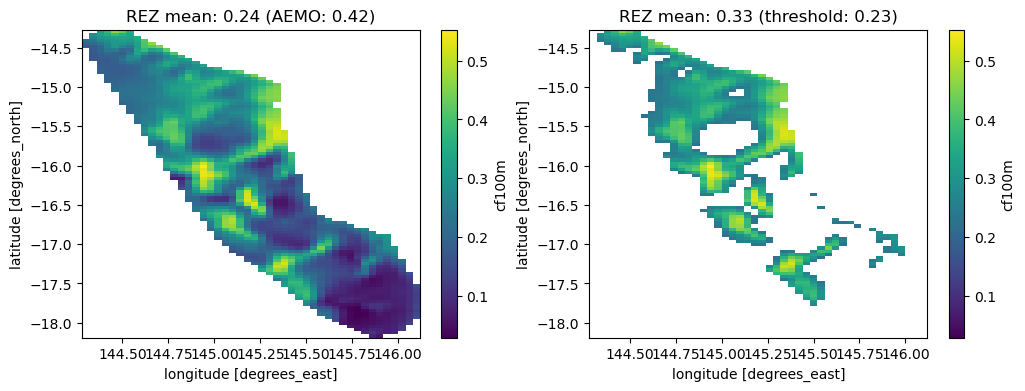

In [148]:
plot_rez_thresh("Q1", q1_mean, q1_thresh, q1_thresh_mean)

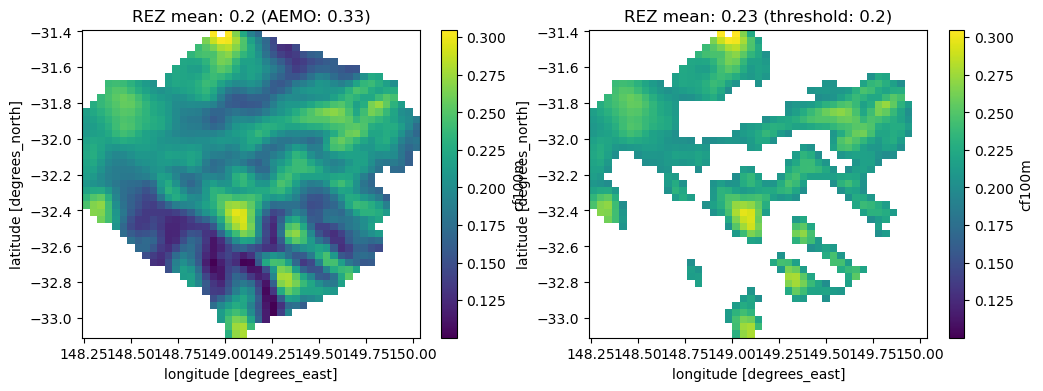

In [149]:
plot_rez_thresh("N3", n3_mean, n3_thresh, n3_thresh_mean)

In [38]:
# plot_rez_thresh("V8", v8_mean, v8_thresh, v8_thresh_mean)

In [39]:
# plot_rez_thresh("S6", s6_mean, s6_thresh, s6_thresh_mean)

In [40]:
# plot_rez_thresh("T3", t3_mean, t3_thresh, t3_thresh_mean)

### Wind droughts - temporal resolution

Compute some rolling mean time series and write to disk

In [27]:
def get_rolling_mean(compute, dataset, da, mask, rez, sampling_frequencies, lengths):
    """
    Return rolling mean arrays for desired sampling frequencies and window lengths

    compute: bool, whether to compute or read
    dataset: str, dataset and directory name e.g. 'BARRA-C2'
    da: array
    mask: array, REZ mask
    rez: str, name of REZ e.g. 'S6'
    sampling_frequencies: list, elements in format '20min' or 'Xhr', where X indicates every X-hourly time step
    lengths: list, elements integers indicating rolling length (in days)
    """
    def _get_skip(t):
        if t == "20min":
            nhrs = 0.33
            skip = None
            hr_time_steps = 24 * 3
        elif t[-2:] == "hr":
            nhrs = int(t[:-2])
            skip = nhrs * 3 # *3 because assumes 20min input data and 0000 first timestep
            hr_time_steps = 24 // nhrs # number of time steps per hour
        else:
            raise ValueError("Incorrect t specified")
        return nhrs, skip, hr_time_steps

    # Get REZ-mean data
    da = da.where(mask.sel(region=rez), drop=True)
    da = da.mean(["lat", "lon"])

    # for each sampling frequency get regional-average array and other variables
    sf_list = []
    roll_list = []
    nhrs_list = []
    for sf in sampling_frequencies:
        _nhr, _skip, _hr_ts = _get_skip(sf)
        
        sf_list.append(da.sel(time=slice(None, None, _skip)))
        roll_list.append(_hr_ts)
        nhrs_list.append(_nhr)

    print(roll_list)
    print(nhrs_list)
    return_list = []
    # For each window length...
    for l in lengths:
        
        len_list = []
        # For each sampling frequency, rolling window and hours-per-timestep
        for (da, roll, nhr) in zip(
            sf_list,
            roll_list,
            nhrs_list
        ):
            filename = "wind_capacity_factor_REZ_"+rez+"_"+str(nhr)+"hr_roll"+str(l)+"day_2011-2023"

            if compute:
                arr = da.chunk({"time": -1}).rolling(time=roll * l).mean()
                # arr = rolling_expand_dim(da, roll)
                arr = arr.to_dataset(name="cf_roll" + str(l) + "day")
                arr.to_netcdf(
                    "/g/data/ng72/dr6273/work/projects/wind_power_comparison/data/" + dataset + "/" + filename + ".nc"
                )
            else:
                arr = xr.open_mfdataset(
                    "/g/data/ng72/dr6273/work/projects/wind_power_comparison/data/" + dataset + "/" + filename + ".nc"
                )
                return_list.append(arr)

    if compute == False:
        
        return_dict = {}
        for i, sf in enumerate(sampling_frequencies):
            
            # Get arrays of a particular sampling
            len_arrays = [return_list[x] for x in range(i, len(return_list), len(sampling_frequencies))]
            
            # Get array from dataset and expand dim
            len_arrays = [
                da[list(da.data_vars)[0]].expand_dims(
                    {"window_len": [int(list(da.data_vars)[0][7:-3])]}
                ) for da in len_arrays
            ]
            
            concat_da = xr.concat(len_arrays, dim="window_len")
            return_dict[sf] = concat_da.compute()
            
        return return_dict

In [28]:
sampling_freqs = ["20min", "1hr", "12hr", "24hr"]
# sampling_freqs = ["3hr", "6hr"]

In [29]:
window_lengths = [1, 2, 3, 5, 7, 10, 14, 21]

In [30]:
roll_cf_S6 = get_rolling_mean(
    False,
    "BARRA-C2",
    cf_barra,
    rez_mask_barra_c2,
    "S6",
    sampling_freqs,
    window_lengths
)

[72, 24, 2, 1]
[0.33, 1, 12, 24]


In [31]:
roll_cf_Q1 = get_rolling_mean(
    False,
    "BARRA-C2",
    cf_barra,
    rez_mask_barra_c2,
    "Q1",
    sampling_freqs,
    window_lengths
)

[72, 24, 2, 1]
[0.33, 1, 12, 24]


In [32]:
# def drought_freq(da, thresh, dim="time"):
#     da = da.dropna("time")
#     return da.where(da < thresh).count(dim) / len(da.time)

In [33]:
def drought_intensity(da, freq, dim="time"):
    da = da.dropna("time")
    return da.where(da < da.quantile(freq, "time")).max("time")

In [36]:
# intensity_thresh = 0.2 # capacity factor threshold

In [35]:
# freq_thresh = 0.2 # quantile of time threshold

In [46]:
def plot_idf(roll_dict, frequency_T, select_0000=False):
    fig, ax = plt.subplots(1, 1)

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:pink"]
    markers = ["o", "s", "^", "v"]

    if frequency_T == "max":
        frequency_T = [1 / len(_da.time) for _da in roll_dict.values()]
        print(frequency_T)

    for c, m, (key, da) in zip(
        colors,
        markers,
        roll_dict.items()
    ):
        # da_daily = da.isel(time=(da.time.dt.hour == 0) & (da.time.dt.minute == 0))
        # print("Len 00:00 time steps:", len(da_daily.time.values), "\n")

        if select_0000:
            da = da.isel(time=(da.time.dt.hour == 0) & (da.time.dt.minute == 0))

        print("N time steps:", len(da.time.values))
        
        if isinstance(frequency_T, float):
            ax.plot(
                da.window_len,
                drought_intensity(da, frequency_T),
                color=c,
                marker=m,
                label=key
            )
            # ax.plot(
            #     da_daily.window_len,
            #     drought_intensity(da_daily, frequency_T),
            #     ls="--",
            #     color=c,
            #     marker=m,
            #     label=key+" daily"
            # )
        else:
            linestyles = ["-", ":", "--", "-."]
            for ls, fT in zip(linestyles[:], frequency_T[:]):
                ax.plot(
                    da.window_len,
                    drought_intensity(da, fT),
                    color=c,
                    ls=ls,
                    marker=m,
                    label=key+" "+str(fT)
                )
                # ax.plot(
                #     da_daily.window_len,
                #     drought_intensity(da_daily, fT),
                #     ls="-.",
                #     color=c,
                #     marker=m,
                #     label=key+" daily"
                # )
    ax.legend()
    ax.set_xlabel("Duration [d]")
    ax.set_ylabel("Capacity factor (intensity) [-]")
    ax.set_title("Sampling frequency vs intensity vs duration")
    ax.set_yticks(np.arange(0, 0.31, 0.1))

N time steps: 341856
N time steps: 113952
N time steps: 9496
N time steps: 4748


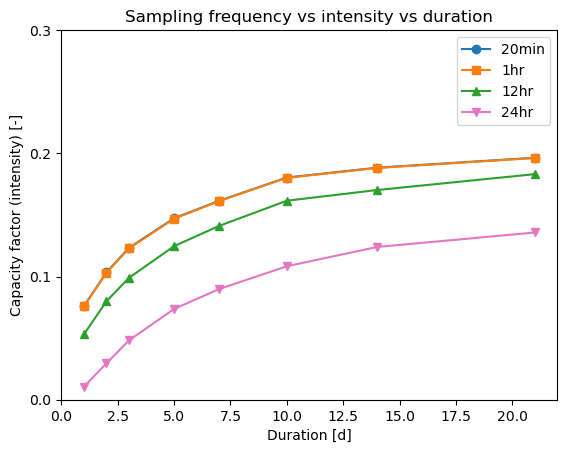

In [47]:
plot_idf(roll_cf_S6, 0.1)

N time steps: 4748
N time steps: 4748
N time steps: 4748
N time steps: 4748


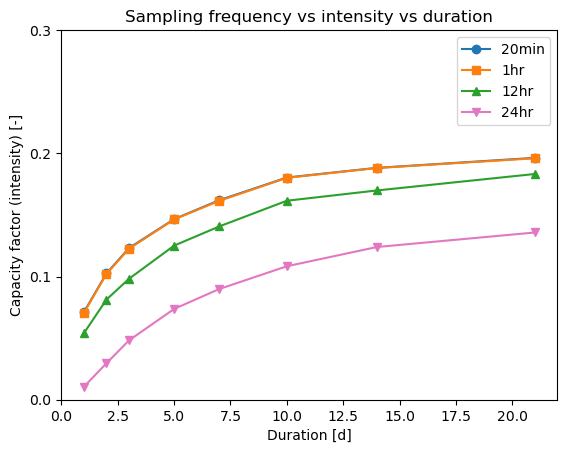

In [48]:
plot_idf(roll_cf_S6, 0.1, select_0000=True)

N time steps: 341856
N time steps: 113952
N time steps: 9496
N time steps: 4748


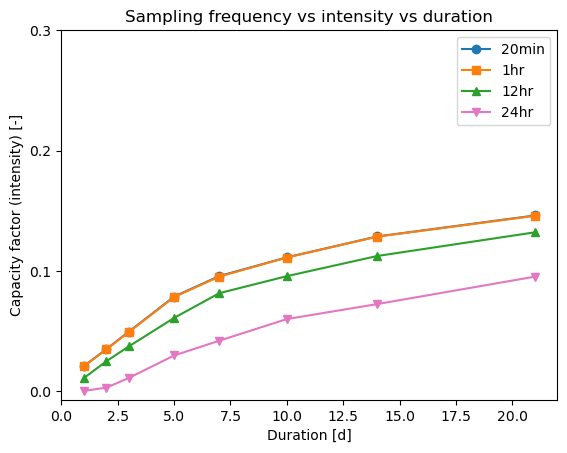

In [49]:
plot_idf(roll_cf_S6, 0.01)

In [50]:
def find_lowest_nonoverlapping(ws, fraction=0.01, window_days=7):
    """
    Find the lowest fraction of non-overlapping events in a rolling-mean wind speed series.

    Parameters
    ----------
    ws : xr.DataArray
        Time series (e.g., 20-min wind speed) with a datetime coordinate named 'time'.
        Should already be smoothed with a rolling mean (e.g., 7-day rolling mean).
    fraction : float
        Fraction of lowest values to extract (e.g., 0.01 = 1% lowest).
    window_days : float
        Number of days to exclude on either side of each selected event.

    Returns
    -------
    xr.DataArray
        With variable:
        - 'wind_speed': values of the selected low events
    """
    ws = ws.dropna(dim="time")
    n_events = max(1, int(len(ws.time) * fraction))
    ws_copy = ws.copy()
    selected = []

    window = pd.Timedelta(days=window_days)

    for rank in range(1, n_events + 1):
        if ws_copy.isnull().all():
            break

        # Find time of current minimum
        tmin = pd.to_datetime(ws_copy.idxmin(dim="time").item())
        val = ws.sel(time=tmin).item()
        selected.append((tmin, val, rank))

        # Mask out ±window_days around that time
        mask = (ws_copy.time < tmin - window) | (ws_copy.time > tmin + window)
        ws_copy = ws_copy.where(mask)

    # Convert to DataArray
    times, vals, ranks = zip(*selected)
    result = xr.DataArray(
        np.asarray(vals),
        dims=["time"],
        coords={"time": pd.to_datetime(times).round("1min")}
    )
    result = result.assign_coords(rank=("time", np.asarray(ranks)))

    return result.sortby("time")

In [149]:
w_len = 1

In [51]:
window_lengths

[1, 2, 3, 5, 7, 10, 14, 21]

In [197]:
%%time
lowest_5pct = find_lowest_nonoverlapping(
    roll_cf_S6["24hr"].sel(window_len=w_len).dropna("time"),
    fraction=0.01,
    window_days=w_len
)

CPU times: user 220 ms, sys: 10.9 ms, total: 231 ms
Wall time: 225 ms


In [199]:
roll_cf_S6["24hr"].sel(window_len=w_len).dropna("time")

<xarray.DataArray 'cf_roll1day' (time: 4748)> Size: 19kB
array([0.02748113, 0.34504956, 0.14890534, ..., 0.422115  , 0.2747019 ,
       0.07517526], dtype=float32)
Coordinates:
    window_len  int64 8B 1
  * time        (time) datetime64[ns] 38kB 2011-01-01 2011-01-02 ... 2023-12-31
    crs         int32 4B 0
    height      float64 8B 100.0
    region      <U2 8B 'S6'

In [198]:
lowest_5pct

<xarray.DataArray (time: 47)> Size: 376B
array([2.21872797e-05, 5.33402999e-06, 2.73911050e-04, 1.77349881e-04,
       8.32417354e-05, 1.12460388e-04, 1.98262060e-04, 3.06669564e-04,
       3.32381693e-04, 7.94310617e-05, 1.31668057e-04, 1.07779204e-04,
       0.00000000e+00, 1.34531772e-04, 6.96443749e-05, 5.96418977e-05,
       0.00000000e+00, 0.00000000e+00, 3.38173617e-04, 2.48131037e-05,
       4.58557042e-06, 1.82080475e-05, 3.88111454e-04, 5.77545834e-05,
       9.55083306e-05, 3.21755157e-04, 2.11011313e-04, 8.26543837e-05,
       3.09644965e-04, 2.20475005e-04, 3.63220985e-04, 2.89893469e-05,
       1.82764707e-04, 3.41049687e-04, 3.88293913e-08, 2.88304400e-05,
       3.79844743e-04, 0.00000000e+00, 5.43260940e-05, 1.94912267e-04,
       2.87022322e-05, 5.74589067e-05, 0.00000000e+00, 0.00000000e+00,
       3.91930007e-05, 8.35404790e-05, 1.69119186e-04])
Coordinates:
  * time     (time) datetime64[ns] 376B 2011-02-17 2011-05-07 ... 2023-04-18
    rank     (time) int64 376B 11 9 38 32 24 28 35 39 ... 34 13 18 5 6 16 25 31

In [200]:
1 / (47 / 13)

0.2765957446808511

In [195]:
def plot_idf(roll_dict, frequency_T):
    fig, ax = plt.subplots(1, 1)

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:pink"]
    markers = ["o", "s", "^", "v"]

    for c, m, (key, da) in zip(
        colors,
        markers,
        roll_dict.items()
    ):
        print("Len all time steps:", len(da.time.values))
        
        # da_daily = da.resample(time="1D").mean()
        da_daily = da.isel(time=(da.time.dt.hour == 0) & (da.time.dt.minute == 0))
        print("Len 00:00 time steps:", len(da_daily.time.values), "\n")
        # ax.axhline(da.mean(), ls="--", color=c)
        
        if isinstance(frequency_T, float):
            
            ax.plot(
                da.window_len,
                # drought_intensity(da, frequency_T),
                color=c,
                marker=m,
                label=key
            )
            # ax.plot(
            #     da_daily.window_len,
            #     drought_intensity(da_daily, frequency_T),
            #     ls="--",
            #     color=c,
            #     marker=m,
            #     label=key+" daily"
            # )
        else:
            linestyles = ["-", ":", "--", "-."]
            for ls, fT in zip(linestyles[:], frequency_T[:]):
                ax.plot(
                    da.window_len,
                    drought_intensity(da, fT),
                    color=c,
                    ls=ls,
                    marker=m,
                    label=key+" "+str(fT)
                )
                # ax.plot(
                #     da_daily.window_len,
                #     drought_intensity(da_daily, fT),
                #     ls="-.",
                #     color=c,
                #     marker=m,
                #     label=key+" daily"
                # )
    ax.legend()
    ax.set_xlabel("Duration [d]")
    ax.set_ylabel("Intensity [-]")
    ax.set_title("Sampling frequency vs intensity vs duration")
    ax.set_yticks(np.arange(0, 0.31, 0.1))

<xarray.DataArray (time: 1139)> Size: 9kB
array([0.12878446, 0.09940289, 0.06422231, ..., 0.08484823, 0.09973182,
       0.10378994])
Coordinates:
  * time     (time) datetime64[ns] 9kB 2011-01-05T08:00:00 ... 2023-12-27T14:...
    rank     (time) int64 9kB 1076 785 470 526 329 1127 ... 660 894 649 795 825

In [196]:
lowest_5pct.mean("time")

<xarray.DataArray ()> Size: 8B
array(0.07487176)

In [184]:
x = roll_cf_S6["20min"].sel(window_len=w_len).dropna("time").sortby(lambda x: x).isel(time=range(341))

In [185]:
x.mean()

<xarray.DataArray 'cf_roll1day' ()> Size: 8B
array(0.0053625)
Coordinates:
    window_len  int64 8B 1
    crs         int32 4B 0
    height      float64 8B 100.0
    region      <U2 8B 'S6'

In [186]:
x

<xarray.DataArray 'cf_roll1day' (time: 341)> Size: 1kB
array([0.00187367, 0.00187644, 0.00188701, 0.00188737, 0.00190395,
       0.00190468, 0.00190473, 0.00190543, 0.00190647, 0.00190662,
       0.00190677, 0.00190702, 0.0019102 , 0.00191849, 0.00192976,
       0.00193544, 0.0019615 , 0.00199312, 0.00201275, 0.00205737,
       0.00214314, 0.00217445, 0.00232317, 0.0023774 , 0.00248507,
       0.00248621, 0.00251254, 0.00252559, 0.00253158, 0.00254796,
       0.00255205, 0.00255781, 0.00256837, 0.00258302, 0.00263051,
       0.00264752, 0.00266854, 0.00271055, 0.00272194, 0.00278829,
       0.00280658, 0.00282239, 0.00286622, 0.00286999, 0.00296793,
       0.00297752, 0.0029845 , 0.00299166, 0.00310125, 0.00313091,
       0.00317014, 0.00324066, 0.00329118, 0.00336368, 0.00341902,
       0.00345793, 0.00346685, 0.00351583, 0.0035495 , 0.00361898,
       0.00362032, 0.00362436, 0.00363205, 0.00363641, 0.00364684,
       0.00366506, 0.00366975, 0.00367532, 0.00368757, 0.00369688,
       0.00369769, 0.00369771, 0.00369783, 0.00369784, 0.00369787,
       0.00369834, 0.00369879, 0.00370137, 0.00370853, 0.0037158 ,
       0.00372103, 0.00372136, 0.00372414, 0.00372979, 0.0037336 ,
       0.00373617, 0.00374768, 0.00375964, 0.00376104, 0.00376474,
       0.0037738 , 0.00378217, 0.00378258, 0.00380013, 0.0038024 ,
       0.00381879, 0.00383   , 0.00384243, 0.00385481, 0.00386072,
...
       0.00708958, 0.00714318, 0.00716448, 0.00719009, 0.00722606,
       0.00726963, 0.00730273, 0.007347  , 0.00740414, 0.0074593 ,
       0.00747239, 0.00751221, 0.00758328, 0.00760642, 0.00764518,
       0.00766131, 0.00766982, 0.00767431, 0.00768166, 0.00768532,
       0.00769433, 0.00769459, 0.00771439, 0.00773774, 0.00774372,
       0.00777044, 0.00777067, 0.00777929, 0.00778446, 0.00781977,
       0.00781984, 0.0078467 , 0.00786741, 0.00787557, 0.00789268,
       0.00791332, 0.00791819, 0.00793294, 0.00797729, 0.00798083,
       0.00798902, 0.00801089, 0.00802147, 0.00806493, 0.00806664,
       0.00812702, 0.0081532 , 0.00817425, 0.0081766 , 0.0081784 ,
       0.00819504, 0.00821127, 0.00823017, 0.00824027, 0.00827204,
       0.0082885 , 0.00829947, 0.0083044 , 0.0083314 , 0.00834446,
       0.00835419, 0.00835499, 0.00835531, 0.00836038, 0.00836786,
       0.00836834, 0.00838144, 0.00838383, 0.00838905, 0.00839972,
       0.00844735, 0.00845095, 0.00846802, 0.0084721 , 0.00847216,
       0.00847599, 0.00847974, 0.00850167, 0.00850315, 0.00852109,
       0.00855006, 0.00855344, 0.00855504, 0.00855684, 0.00856694,
       0.00857564, 0.00859468, 0.00860685, 0.00860776, 0.00861546,
       0.00862108, 0.00862714, 0.00863149, 0.00866434, 0.00867338,
       0.00868017], dtype=float32)
Coordinates:
    window_len  int64 8B 1
  * time        (time) datetime64[ns] 3kB 2016-07-08T06:40:00 ... 2013-06-18T...
    crs         int32 4B 0
    height      float64 8B 100.0
    region      <U2 8B 'S6'

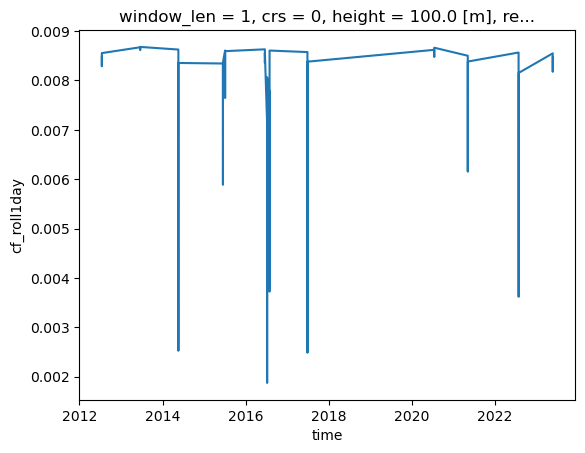

In [187]:
x.sortby("time").plot()

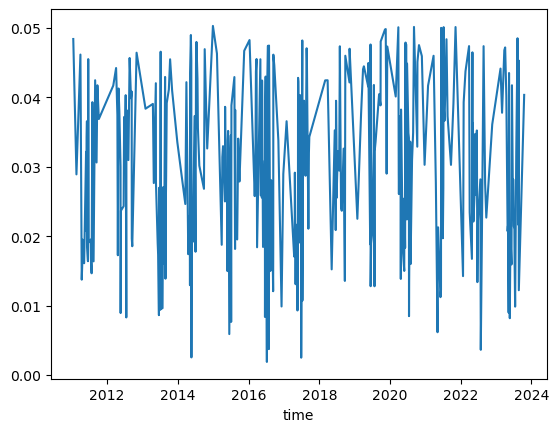

In [188]:
lowest_5pct.plot()

(array([324., 422., 436., 452., 418., 403., 338., 249., 231., 144.]),
 array([0.00187367, 0.04785345, 0.09383323, 0.13981301, 0.18579279,
        0.23177257, 0.27775235, 0.32373213, 0.36971191, 0.41569169,
        0.46167147]),
 <BarContainer object of 10 artists>)

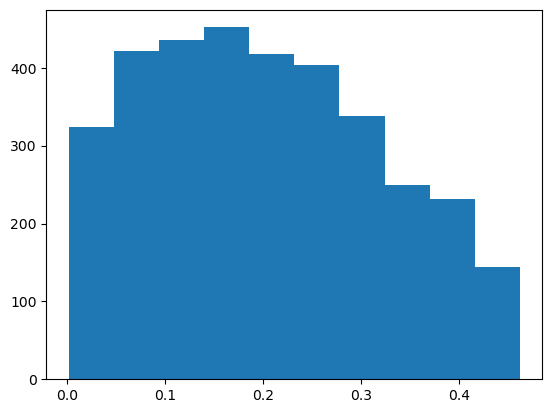

In [180]:
plt.hist(lowest_5pct)